In [29]:
!pip install transformers[torch]

In [30]:
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pathlib
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import re
import pickle
torch.manual_seed(21)

Uzimamo samo trecinu polaznog skupa, jer nismo imali resursa da istreniramo nad celim

In [32]:
df = pd.read_csv('../datasets/fake-news/balansed_fake_news_dataset.csv')

df = df.sample(n=int(df.shape[0] / 3))
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16516 entries, 4605 to 39567
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    16516 non-null  object
 1   text     16514 non-null  object
 2   subject  16516 non-null  object
 3   date     11421 non-null  object
 4   fake     16516 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 661.3+ KB


,title,text,subject,date,fake
4605,"Clinton, Trump draw battle lines for ill-tempe...",WASHINGTON (Reuters) - U.S. presidential candi...,politicsNews,"June 6, 2016",False
39946,"ON THE MOVE: [Video] Iranians, Russians And Sy...",How many more days remain in our Community Org...,politics,"Sep 25, 2015",True
22767,Michigan cancer doctor gets 45 years in prison,(CNN) A doctor who authorities say gave can...,various,NaN,False
47996,CIA GATEKEEPER? CNN’s Chris Cuomo says America...,21st Century Wire says CNN s Chris Cuomo (ima...,Middle-east,"October 20, 2016",True
8013,"France, keen to avoid student anger, plans 1-b...",PARIS (Reuters) - France announced a one-billi...,worldnews,"October 30, 2017",False
5941,Eurosceptics baulk as May pitches status quo B...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"December 18, 2017",False
8438,China summons British official over Hong Kong ...,BEIJING (Reuters) - China has summoned a Briti...,worldnews,"October 20, 2017",False
28559,It’s Really Happening: Trump Adviser Lays Out...,"Well, that didn t take long. In the short time...",News,"November 16, 2016",True
46355,TRUMP THREATENS TO SUE ILLEGAL IMMIGRANT ACTIV...,America better wake up and realize we are quic...,left-news,"Jul 9, 2015",True
5658,Brexit deal could be template for EU ties to U...,BERLIN (Reuters) - An EU agreement with Britai...,worldnews,"December 26, 2017",False


# New Section

In [33]:
df['word_count'] = df['text'].str.count(' ') + 1

In [34]:
def simple_text_clean(x):
  x = str(x)

  x = x.lower()
  x = x.encode('ascii', 'ignore').decode()
  x = re.sub(r'https*\S+', ' ', x)
  x = re.sub(r'http*\S+', ' ', x)
  x = re.sub(r'\'\w+', '', x)
  x = re.sub(r'\w*\d+\w*', '', x)
  x = re.sub(r'\s{2,}', ' ', x)
  x = re.sub(r'\s[^\w\s]\s', '', x)
  return x

In [35]:
df['cleaned_text'] = df['text'].apply(simple_text_clean)

In [36]:
df['word_count_cleaned'] = df['cleaned_text'].str.count(' ') + 1

In [37]:
df.head(10)

,title,text,subject,date,fake,word_count,cleaned_text,word_count_cleaned
4605,"Clinton, Trump draw battle lines for ill-tempe...",WASHINGTON (Reuters) - U.S. presidential candi...,politicsNews,"June 6, 2016",False,954.0,washington (reuters)u.s. presidential candidat...,909
39946,"ON THE MOVE: [Video] Iranians, Russians And Sy...",How many more days remain in our Community Org...,politics,"Sep 25, 2015",True,791.0,how many more days remain in our community org...,759
22767,Michigan cancer doctor gets 45 years in prison,(CNN) A doctor who authorities say gave can...,various,NaN,False,933.0,(cnn) a doctor who authorities say gave cance...,876
47996,CIA GATEKEEPER? CNN’s Chris Cuomo says America...,21st Century Wire says CNN s Chris Cuomo (ima...,Middle-east,"October 20, 2016",True,521.0,"century wire says cnn s chris cuomo (image, a...",488
8013,"France, keen to avoid student anger, plans 1-b...",PARIS (Reuters) - France announced a one-billi...,worldnews,"October 30, 2017",False,384.0,paris (reuters)france announced a one-billion-...,362
5941,Eurosceptics baulk as May pitches status quo B...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"December 18, 2017",False,578.0,london (reuters)british prime minister theresa...,549
8438,China summons British official over Hong Kong ...,BEIJING (Reuters) - China has summoned a Briti...,worldnews,"October 20, 2017",False,278.0,beijing (reuters)china has summoned a british ...,262
28559,It’s Really Happening: Trump Adviser Lays Out...,"Well, that didn t take long. In the short time...",News,"November 16, 2016",True,534.0,"well, that didn t take long. in the short time...",521
46355,TRUMP THREATENS TO SUE ILLEGAL IMMIGRANT ACTIV...,America better wake up and realize we are quic...,left-news,"Jul 9, 2015",True,597.0,america better wake up and realize we are quic...,577
5658,Brexit deal could be template for EU ties to U...,BERLIN (Reuters) - An EU agreement with Britai...,worldnews,"December 26, 2017",False,378.0,berlin (reuters)an eu agreement with britain o...,359


In [38]:
MAX_PARAGRAF = 400
STEP = 220

def splitIntoParagrafs(text, words):
  paragrafs = []
  if words < MAX_PARAGRAF:
    return [text]
  else:
    start = 0
    end = MAX_PARAGRAF
    tokens = text.split(' ')
    while start < words:
      paragrafs.append(' '.join(tokens[start:end]))
      start += STEP
      end += STEP

  return paragrafs



In [39]:
tokenizer_df = pd.DataFrame(columns=['text', 'target'])


for i in tqdm(range(len(df))):
  for j in splitIntoParagrafs(df.iloc[i, 6], df.iloc[i, 7]):
    tokenizer_df = tokenizer_df.append({'text': j, 'target': df.iloc[i, 4]}, ignore_index=True)


100%|██████████| 16516/16516 [01:24<00:00, 195.21it/s]


In [40]:
tokenizer_df.head(10)

,text,target
0,washington (reuters)u.s. presidential candidat...,False
1,talk about why hes unqualified to be president...,False
2,"from vermont, nearly out of options to challen...",False
3,there would be a revolt against him when deleg...,False
4,eventual endorsement would put pressure on san...,False
5,how many more days remain in our community org...,True
6,"has voiced concern that russia s involvement, ...",True
7,"fly directly from russia to syria, but the sma...",True
8,carter cautioned that without russian support ...,True
9,(cnn) a doctor who authorities say gave cance...,False


[17292, 21309]


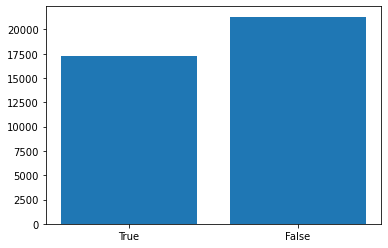

In [41]:
targets=['True', 'False']
t_num = tokenizer_df[tokenizer_df['target']==1].count().target
f_num = tokenizer_df[tokenizer_df['target']==0].count().target
h=[t_num, f_num]
x = np.arange(len(targets))

print(h)
plt.bar(x, h)
plt.xticks(x, targets)
plt.show()

In [42]:
tokenizer_df.to_csv('../datasets/fake-news/tokenizer_df.csv', index=False)

In [43]:
df = pd.read_csv('../datasets/fake-news/tokenizer_df.csv')
df.head(10)

,text,target
0,washington (reuters)u.s. presidential candidat...,False
1,talk about why hes unqualified to be president...,False
2,"from vermont, nearly out of options to challen...",False
3,there would be a revolt against him when deleg...,False
4,eventual endorsement would put pressure on san...,False
5,how many more days remain in our community org...,True
6,"has voiced concern that russia s involvement, ...",True
7,"fly directly from russia to syria, but the sma...",True
8,carter cautioned that without russian support ...,True
9,(cnn) a doctor who authorities say gave cance...,False


In [44]:
print(df['text'])
print(len(df))

0        washington (reuters)u.s. presidential candidat...
1        talk about why hes unqualified to be president...
2        from vermont, nearly out of options to challen...
3        there would be a revolt against him when deleg...
4        eventual endorsement would put pressure on san...
                               ...                        
38596    the government to enact the peace agreement sw...
38597    the accords stopped short of the demands of so...
38598    time that his endorsement may have actually hu...
38599    the left is trying to push the narrative that ...
38600    as much as many of us wish there were a legiti...
Name: text, Length: 38601, dtype: object
38601


In [45]:
print(df.text.str.count(' ').max())

399.0


In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'], df['target'], test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)



(30880,) (30880,)
(7721,) (7721,)


In [47]:
print(X_train)

26276    democratic presidential nominee hillary clinto...
34949    when former president george w. bush left offi...
9606     as obama pushes to close gitmo, two former det...
35089    report estimates the annual costs of illegal i...
23721    after tuesday s semi-coronation of donald trum...
                               ...                        
6265      century wire says it appears that putin has h...
11284    nightly show host larry wilmore lightheartedly...
38158    he released the man who had been thrown into p...
860      s] husband while [hiswas still alive, handcuff...
15795    tune in to the alternate current radio network...
Name: text, Length: 30880, dtype: object


In [48]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
emb_words = []
labels = []
for i in tqdm(range(len(X_train))):
  encoded_input = tokenizer(str(X_train.iloc[i]), return_tensors='pt', truncation=True)
  output = model(**encoded_input)
  words = output['pooler_output'][0].detach().numpy()
  emb_words.append(words)
  labels.append(Y_train.iloc[i])

100%|██████████| 30880/30880 [3:49:22<00:00,  2.24it/s]  


In [50]:
X = np.array(emb_words)
y = np.array(labels)
print(X.shape)
print(y.shape)

(30880, 768)
(30880,)


In [51]:
print(y)

[False  True  True ... False False  True]


In [53]:
clf = SVC(kernel='linear')
clf.fit(X, y)


SVC(kernel='linear')

In [54]:
pickle.dump(clf, open('../datasets/fake-news/clf.sav', 'wb'))

In [55]:
clf = pickle.load(open('../datasets/fake-news/clf.sav', 'rb'))

In [56]:
emb_words_test = []
labels_test = []
for i in range(len(X_test)):
  encoded_input = tokenizer(str(X_test.iloc[i]), return_tensors='pt', truncation=True)
  output = model(**encoded_input)
  words = output['pooler_output'][0].detach().numpy()
  emb_words_test.append(words)
  labels_test.append(Y_test.iloc[i])

In [57]:
X_svm_test = np.array(emb_words_test)
print(X_svm_test.shape)

(7721, 768)


In [58]:
predicted = clf.predict(X_svm_test)

print(accuracy_score(labels_test, predicted))

0.9268229503950266
